# Information on How These Data Are Organized:

`TypeOfResponse` refers to whether participants pressed a button ("SCTResp") or did not press a button ("SCTRespITI" / "SCTITIResp") within the given time frame.

`Version` refers to the task version. I never changed the JS code; I merely changed which face/house was labeled as S1_1, S1_2, S1_3, or S1_4 in respective task folders.

`LogCounter` gets added to whenever the JS records a new datapoint.

`TrialCounter` gets added to whenever a new trial has started. This is reset at the start of each block.

`MatrixCounter` gets added to throughout the task and is never reset. It is what I use to call Stimuli #s.

`RunCounter` refers to the run: 0 is run 1, 1 is run 2.

`CongruentCounter` marks any time a congruent trial occurred; `IncongruentCounter` an incongruent trial.

`StimPresented` refers to which face or house was presented before the trial. This is in reference to the main manipulation of the S-CT test phase: we examine whether congruency effects are modulated through previously learned associations with the S2 control-demand cues.

`StimProbAll` refers to my matrix of possible trial types. So it indicates whether "RED" will be shown in red, etc.

`TrialType` also marks incongruent/congruent trials.

`CongruentNumber` refers to my specially made matrices of my congruent trials. So there are 4 possible incongruent combinations, with 80 total congruent trials, and thus 20 occurrences of numbers 1-4.

`IncongruentNumber` refers to my specially made matrix of incongruent trials. There are 12 possible incongruent combinations, with 80 trial incongruent trials, and thus around 6 of each occurrence.

`PressCorrect` refers to the button that participants should press on that trial. This is how I define accuracy (i.e., correct: when PressCorrect = actualkeyPressed).

`ResponseMatrix` refers to which key is pressed; this is a redundant variable and was used to make sure that each key had been required an equal number of times throughout the task.

`ActualKeyPressed` is what key subjects pressed.

`Accuracy` & `RT` self-explanatory.

`FeedbackType` refers to whether they got correct as fb, incorrect as fb, or the fb time-out.

`runStart` refers to the initiation of the countdown to begin the task.

`ImagePresent` refers to when scene was presented.

`StimTime` refers to when the color word was presented.

`RespOnset` refers to when a response was made.

`AccCount` is how I give subjects accurate fb of their performance at the end of each run (i.e., a counter that gets added to after each correct trial & is divided by trial #).

`Subject` self-explanatory.

Some other labels aren't coded in the JS: `Sequential` refers to whether a trial was the same (0) as before, changed to incongruent or congruent on the next trial, etc., and `StimRep` looks for direct repetitions in the StimProbAll matrix. These were coded in Matlab and added to the CSV file.

---

In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pylab as plb
import math
from scipy import stats

%matplotlib notebook 

In [90]:
%run 'SCAnalysis.ipynb'
%cd ..
%cd 'data'
dat = pd.read_csv('AllSubsSCT.csv')

C:\Users\cb383\Documents\controltransfer\expt1\data
[WinError 2] The system cannot find the file specified: 'data'
C:\Users\cb383\Documents\controltransfer\expt1\data


ERROR: File `'SCAnalysis.ipynb.py'` not found.


# Do some basic cleaning

#### We are filtering and preparing the data for analysis.

FOR REACTION TIMES:

-Select only `TypeOfResponse` equal to `Resp` (`ITI Resp` is when subs didn't respond).

-Only take the RTs that are greater than 200ms and less than 1000 ms.

-Only take the RTs on accurate trials.

-Only take trials where the stimulus didn't repeat.


FOR ACCURACY:

-All errors are errors

In [91]:
cdat = dat.query('(TypeOfResponse != "SCTRespITI") & (TypeOfResponse != "SCTITIResp") & (RT > 200) & (RT < 1000) & (Accuracy != 0) & (StimRep != 1)').copy()
adat = dat.copy()

#### Now I'm making columns in the data based off my variables so that analysis will be easier.

In [92]:
adat['TransferProbe'] = adat['StimPresented'].isin([1, 2])
adat.loc[adat['StimPresented'].isin([1, 2]), 'TransferProbe'] = 'High'
adat.loc[~adat['StimPresented'].isin([1, 2]), 'TransferProbe'] = 'Low'

adat['Congruency'] = adat['TrialType'].isin([1])
adat.loc[adat['TrialType'].isin([1]),'Congruency'] = 'Incongruent'
adat.loc[~adat['TrialType'].isin([1]),'Congruency'] = 'Congruent'

cdat['TransferProbe'] = cdat['StimPresented'].isin([1, 2])
cdat.loc[cdat['StimPresented'].isin([1, 2]), 'TransferProbe'] = 'High'
cdat.loc[~cdat['StimPresented'].isin([1, 2]), 'TransferProbe'] = 'Low'

cdat['Congruency'] = cdat['TrialType'].isin([1])
cdat.loc[cdat['TrialType'].isin([1]),'Congruency'] = 'Incongruent'
cdat.loc[~cdat['TrialType'].isin([1]),'Congruency'] = 'Congruent'

In [93]:
adat['ContextCong'] = adat['TransferProbe'].isin(['High']) & adat['TrialType'].isin([1])
adat.loc[(adat['TransferProbe'].isin(['High']) & adat['TrialType'].isin([1])), 'ContextCong'] = 'HighIC'
adat.loc[(adat['TransferProbe'].isin(['Low']) & adat['TrialType'].isin([1])), 'ContextCong'] = 'LowIC'
adat.loc[(adat['TransferProbe'].isin(['High']) & adat['TrialType'].isin([2])), 'ContextCong'] = 'HighC'
adat.loc[(adat['TransferProbe'].isin(['Low']) & adat['TrialType'].isin([2])), 'ContextCong'] = 'LowC'

cdat['ContextCong'] = cdat['TransferProbe'].isin(['High']) & cdat['TrialType'].isin([1])
cdat.loc[(cdat['TransferProbe'].isin(['High']) & cdat['TrialType'].isin([1])), 'ContextCong'] = 'HighIC'
cdat.loc[(cdat['TransferProbe'].isin(['Low']) & cdat['TrialType'].isin([1])), 'ContextCong'] = 'LowIC'
cdat.loc[(cdat['TransferProbe'].isin(['High']) & cdat['TrialType'].isin([2])), 'ContextCong'] = 'HighC'
cdat.loc[(cdat['TransferProbe'].isin(['Low']) & cdat['TrialType'].isin([2])), 'ContextCong'] = 'LowC'

# Look at Mean Cueing Effects

### We are hoping to see an interaction between transfer probe and congruency, such that people use the cues to modulate Stroop congruency at first (run 1) but then realize that these cues are not actually useful (run 2). Namely, we would predict that people would have a smaller difference between the Stroop trial types for the "high" compared to "low" transfer probe. This would result from learning to associate a state of higher attentional focus with the high transfer probe via its associated control-demand cue, which in turn means more efficient processing - or responding quicker to incongruent trials and potentially slower to congruent trials. This effect should dissipate after run 1 because these probes are non-predictive.

In [94]:
sub_RTmeans = cdat.groupby(['subject','ContextCong'])['RT'].mean()
RTgrpmean = pd.Series.mean(sub_RTmeans,level=1)
RTgrpmean

ContextCong
HighC     630.906776
HighIC    697.366531
LowC      626.366856
LowIC     695.458950
Name: RT, dtype: float64

In [95]:
RTgrpstd = pd.Series.std(sub_RTmeans,level=1)
RTgrpstd

ContextCong
HighC     48.625043
HighIC    46.295489
LowC      46.111523
LowIC     47.546607
Name: RT, dtype: float64

In [96]:
n = math.sqrt(76)
RTstderror = RTgrpstd / n
RTstderror

ContextCong
HighC     5.577675
HighIC    5.310457
LowC      5.289354
LowIC     5.453970
Name: RT, dtype: float64

#### Judging by these initial numbers, we are unlikely to find an interaction between cue & congruency, at least when looking at both runs together. Is that true of Accuracy?

In [97]:
sub_ACCmeans = adat.groupby(['subject','ContextCong'])['Accuracy'].mean()
ACCgrpmean = pd.Series.mean(sub_ACCmeans,level=1)
ACCgrpmean

ContextCong
HighC     0.947368
HighIC    0.899671
LowC      0.950000
LowIC     0.894737
Name: Accuracy, dtype: float64

In [98]:
ACCgrpstd = pd.Series.std(sub_ACCmeans,level=1)
ACCgrpstd

ContextCong
HighC     0.050428
HighIC    0.072858
LowC      0.056125
LowIC     0.063419
Name: Accuracy, dtype: float64

In [99]:
ACCstderror = ACCgrpstd / n
ACCstderror

ContextCong
HighC     0.005784
HighIC    0.008357
LowC      0.006438
LowIC     0.007275
Name: Accuracy, dtype: float64

#### Okay, since transfer is expected to be run sensitive, what about only for Run 1 data?

In [100]:
sub_RTmeans_Run1 = cdat.loc[cdat['RunCounter'] < 1].groupby(['subject','ContextCong'])['RT'].mean()
RTgrpmean_Run1 = pd.Series.mean(sub_RTmeans_Run1,level=1)
RTgrpmean_Run1

ContextCong
HighC     634.966002
HighIC    693.996381
LowC      625.164399
LowIC     696.947905
Name: RT, dtype: float64

In [101]:
RTgrpstd_Run1 = pd.Series.std(sub_RTmeans_Run1,level=1)
RTgrpstd_Run1

ContextCong
HighC     53.438750
HighIC    46.542874
LowC      48.611354
LowIC     48.640455
Name: RT, dtype: float64

In [102]:
n = math.sqrt(76)
RTstderror_Run1 = RTgrpstd_Run1 / n
RTstderror_Run1

ContextCong
HighC     6.129845
HighIC    5.338834
LowC      5.576105
LowIC     5.579443
Name: RT, dtype: float64

#### Looks like RT may show an interaction between our factors. Accuracy?

In [103]:
sub_ACCmeans_Run1 = adat.loc[adat['RunCounter'] < 1].groupby(['subject','ContextCong'])['Accuracy'].mean()
ACCgrpmean_Run1 = pd.Series.mean(sub_ACCmeans_Run1,level=1)
ACCgrpmean_Run1

ContextCong
HighC     0.944079
HighIC    0.905921
LowC      0.947368
LowIC     0.914474
Name: Accuracy, dtype: float64

In [104]:
ACCgrpstd_Run1 = pd.Series.std(sub_ACCmeans_Run1,level=1)
ACCgrpstd_Run1

ContextCong
HighC     0.061083
HighIC    0.078302
LowC      0.063715
LowIC     0.072946
Name: Accuracy, dtype: float64

In [105]:
ACCstderror_Run1 = ACCgrpstd_Run1 / n
ACCstderror_Run1

ContextCong
HighC     0.007007
HighIC    0.008982
LowC      0.007309
LowIC     0.008367
Name: Accuracy, dtype: float64

# Creating Variables to Run Statistics

#### This is a Python set of analyses, where the data above are organized in what's called "long-form" and to run statistics, I need "wide-form" data. So I am creating a new "dataframe" with the RT and accuracy means for congruent & incongruent trials, after presentation of the low & high control-demand cue, for each subject.

In [106]:
RTanalysis = pd.DataFrame()
lists = [[] for list in range(0,7)]

for ID in range(10,86):
    sub = cdat[cdat.subject == ID]
    lists[0].append(ID)
    LowCRT_trials = sub[sub.ContextCong == 'LowC'].RT.mean()
    LowICRT_trials = sub[sub.ContextCong == 'LowIC'].RT.mean()
    HighCRT_trials = sub[sub.ContextCong == 'HighC'].RT.mean()
    HighICRT_trials = sub[sub.ContextCong == 'HighIC'].RT.mean()    
    lists[1].append(LowCRT_trials)
    lists[2].append(LowICRT_trials)
    lists[3].append(HighCRT_trials)
    lists[4].append(HighICRT_trials)
    
RTanalysis['SubjectID'] = lists[0]
RTanalysis['LowC'] = lists[1]
RTanalysis['LowIC'] = lists[2]
RTanalysis['HighC'] = lists[3]
RTanalysis['HighIC'] = lists[4]

In [107]:
ACCanalysis = pd.DataFrame()
new_lists = [[] for list in range(0,7)]

for ID in range(10,86):
    sub = adat[adat.subject == ID]
    new_lists[0].append(ID)
    LowCACC_trials = sub[sub.ContextCong == 'LowC'].Accuracy.mean()
    LowICACC_trials = sub[sub.ContextCong == 'LowIC'].Accuracy.mean()
    HighCACC_trials = sub[sub.ContextCong == 'HighC'].Accuracy.mean()
    HighICACC_trials = sub[sub.ContextCong == 'HighIC'].Accuracy.mean()    
    new_lists[1].append(LowCACC_trials)
    new_lists[2].append(LowICACC_trials)
    new_lists[3].append(HighCACC_trials)
    new_lists[4].append(HighICACC_trials)
    
ACCanalysis['SubjectID'] = new_lists[0]
ACCanalysis['LowC'] = new_lists[1]
ACCanalysis['LowIC'] = new_lists[2]
ACCanalysis['HighC'] = new_lists[3]
ACCanalysis['HighIC'] = new_lists[4]

In [108]:
#now for run as well

RTrunanalysis = pd.DataFrame()
new_RTlists = [[] for list in range(0,8)]

for ID in range(10,86):
    sub = cdat[cdat.subject == ID]
    for runID in range(0,2):
        run = sub[sub.RunCounter == runID]
        new_RTlists[0].append(ID)
        new_RTlists[1].append(runID)
        LowCRT_trials = run[run.ContextCong == 'LowC'].RT.mean()
        LowICRT_trials = run[run.ContextCong == 'LowIC'].RT.mean()
        HighCRT_trials = run[run.ContextCong == 'HighC'].RT.mean()
        HighICRT_trials = run[run.ContextCong == 'HighIC'].RT.mean()    
        new_RTlists[2].append(LowCRT_trials)
        new_RTlists[3].append(LowICRT_trials)
        new_RTlists[4].append(HighCRT_trials)
        new_RTlists[5].append(HighICRT_trials)
    
RTrunanalysis['SubjectID'] = new_RTlists[0]
RTrunanalysis['Run'] = new_RTlists[1]
RTrunanalysis['LowC'] = new_RTlists[2]
RTrunanalysis['LowIC'] = new_RTlists[3]
RTrunanalysis['HighC'] = new_RTlists[4]
RTrunanalysis['HighIC'] = new_RTlists[5]

In [109]:
#repeat for accuracy

ACCrunanalysis = pd.DataFrame()
new_acclists = [[] for list in range(0,8)]

for ID in range(10,86):
    sub = adat[adat.subject == ID]
    for runID in range(0,2):
        run = sub[sub.RunCounter == runID]
        new_acclists[0].append(ID)
        new_acclists[1].append(runID)
        LowCACC_trials = run[run.ContextCong == 'LowC'].Accuracy.mean()
        LowICACC_trials = run[run.ContextCong == 'LowIC'].Accuracy.mean()
        HighCACC_trials = run[run.ContextCong == 'HighC'].Accuracy.mean()
        HighICACC_trials = run[run.ContextCong == 'HighIC'].Accuracy.mean()    
        new_acclists[2].append(LowCACC_trials)
        new_acclists[3].append(LowICACC_trials)
        new_acclists[4].append(HighCACC_trials)
        new_acclists[5].append(HighICACC_trials)
    
ACCrunanalysis['SubjectID'] = new_acclists[0]
ACCrunanalysis['Run'] = new_acclists[1]
ACCrunanalysis['LowC'] = new_acclists[2]
ACCrunanalysis['LowIC'] = new_acclists[3]
ACCrunanalysis['HighC'] = new_acclists[4]
ACCrunanalysis['HighIC'] = new_acclists[5]

# Run Actual Statistics

#### For the S-CT phase, we run a repeated-measures ANOVA comparing RTs and accuracies for transfer probe (low/high) & congruency (congruent/incongruent) & run (2).

Unfortunately, Python does not have the capability for repeated-measures ANOVA. I could install "pyvtttbl" for Python, but it's not as accurate as R, SPSS, etc. So in this particular notebook, I will run a paired t-test for the interaction effect, and I will include R code to run the ANOVA.

In [110]:
#For overall RT interaction

LowCongDiff = RTanalysis.LowIC - RTanalysis.LowC;
HighCongDiff = RTanalysis.HighIC - RTanalysis.HighC;
stats.ttest_rel(LowCongDiff, HighCongDiff)

Ttest_relResult(statistic=0.73824742060200343, pvalue=0.46266795569518504)

In [111]:
#For overall Accuracy interaction

LowCongDiffACC = ACCanalysis.LowIC - ACCanalysis.LowC;
HighCongDiffACC = ACCanalysis.HighIC - ACCanalysis.HighC;
stats.ttest_rel(LowCongDiffACC, HighCongDiffACC)

Ttest_relResult(statistic=-0.80377664518476943, pvalue=0.42406624414971394)

In [112]:
Run1RT = RTrunanalysis.loc[RTrunanalysis['Run'] < 1]
Run1ACC = ACCrunanalysis.loc[RTrunanalysis['Run'] < 1]

In [113]:
#For run 1 RT interaction

LowCongDiff_R1 = Run1RT.LowIC - Run1RT.LowC;
HighCongDiff_R1 = Run1RT.HighIC - Run1RT.HighC;
stats.ttest_rel(LowCongDiff_R1, HighCongDiff_R1)

Ttest_relResult(statistic=2.2104673374599271, pvalue=0.030122139032489319)

In [114]:
#For run 1 Accuracy interaction

LowCongDiffACC_R1 = Run1ACC.LowIC - Run1ACC.LowC;
HighCongDiffACC_R1 = Run1ACC.HighIC - Run1ACC.HighC;
stats.ttest_rel(LowCongDiffACC_R1, HighCongDiffACC_R1)

Ttest_relResult(statistic=0.38184816280960343, pvalue=0.70365376752761766)

In [153]:
SCTRTcueing = LowCongDiff_R1 - HighCongDiff_R1;
SCTACCcueing = LowCongDiffACC_R1 - HighCongDiffACC_R1;

%store -r SCRTcueing
%store -r SCACCcueing

In [116]:
#can look at more things, like Bayesian confidence intervals
stats.bayes_mvs(RTanalysis.LowC);
stats.bayes_mvs(RTanalysis.LowIC);
stats.bayes_mvs(RTanalysis.HighC);
stats.bayes_mvs(RTanalysis.HighIC);
stats.bayes_mvs(ACCanalysis.LowC);
stats.bayes_mvs(ACCanalysis.LowIC);
stats.bayes_mvs(ACCanalysis.HighC);
stats.bayes_mvs(ACCanalysis.HighIC);

#### In sum: significant interaction & a main effect of congruency on RT for run 1 of transfer data

# Look at the Results Graphically

Note that the graphs generated mimic the paper, but I used Matlab to generate the figures, because I like their graphics more.

In [117]:
sns.set(context='notebook', style='white', font='Myriad Pro', font_scale=2, color_codes=False, rc=None);

<IPython.core.display.Javascript object>


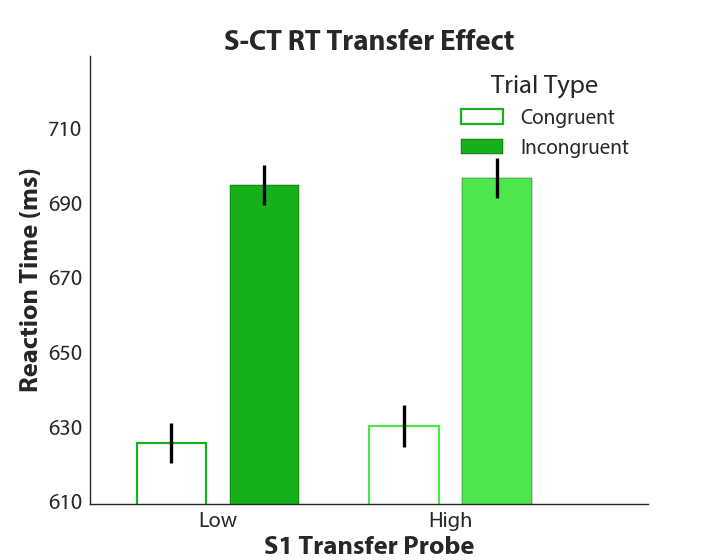

In [118]:
barwidth = 0.75; 
fig, ax = plt.subplots(figsize=(9, 7));
rects1 = ax.bar(0.5,RTanalysis.LowC.mean(),barwidth,yerr=RTstderror.LowC,ecolor='k',edgecolor=sns.xkcd_rgb['green'],linewidth = 2, facecolor='none',error_kw=dict(lw=3),label='Congruent');
rects2 = ax.bar(1.5,RTanalysis.LowIC.mean(),barwidth,color=sns.xkcd_rgb['green'],yerr=RTstderror.LowIC,ecolor='k',error_kw=dict(lw=3),label='Incongruent');
rects3 = ax.bar(3,RTanalysis.HighC.mean(),barwidth,yerr=RTstderror.HighC,ecolor='k',edgecolor=(0.3,0.9,0.3),linewidth = 2, facecolor='none',error_kw=dict(lw=3));
rects4 = ax.bar(4,RTanalysis.HighIC.mean(),barwidth,color=(0.3,0.9,0.3),yerr=RTstderror.HighIC,ecolor='k',error_kw=dict(lw=3));
sns.set(context='notebook', style='white', font='Myriad Pro', font_scale=2, color_codes=False, rc=None);
ax.set_ylim(610,730);
ax.set_xlim(0,6);
ax.set_xticklabels(('Low', 'High'));
ax.set_xticks([1 + barwidth/2, 3.5 + barwidth/2]);
ax.set_yticks(np.arange(610, 711, 20));
plt.legend([rects1,rects2], ['Congruent','Incongruent'], loc='upper right',fontsize=18,title='Trial Type');
plt.legend(title='Trial Type',fontsize=19);
plt.title('S-CT RT Transfer Effect', fontsize=26,fontweight="bold");
plt.ylabel('Reaction Time (ms)', fontsize=24,fontweight="bold");
plt.xlabel('S1 Transfer Probe', fontsize=24,fontweight="bold");
sns.despine();

plt.show()

<IPython.core.display.Javascript object>


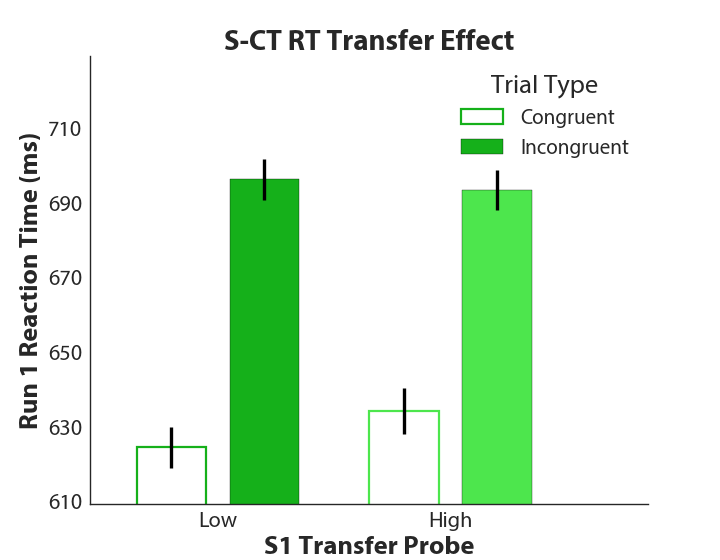

In [119]:
barwidth = 0.75; 
fig, ax = plt.subplots(figsize=(9, 7));
rects1 = ax.bar(0.5,Run1RT.LowC.mean(),barwidth,yerr=RTstderror_Run1.LowC,ecolor='k',edgecolor=sns.xkcd_rgb['green'],linewidth = 2, facecolor='none',error_kw=dict(lw=3),label='Congruent');
rects2 = ax.bar(1.5,Run1RT.LowIC.mean(),barwidth,color=sns.xkcd_rgb['green'],yerr=RTstderror_Run1.LowIC,ecolor='k',error_kw=dict(lw=3),label='Incongruent');
rects3 = ax.bar(3,Run1RT.HighC.mean(),barwidth,yerr=RTstderror_Run1.HighC,ecolor='k',edgecolor=(0.3,0.9,0.3),linewidth = 2, facecolor='none',error_kw=dict(lw=3));
rects4 = ax.bar(4,Run1RT.HighIC.mean(),barwidth,color=(0.3,0.9,0.3),yerr=RTstderror_Run1.HighIC,ecolor='k',error_kw=dict(lw=3));
sns.set(context='notebook', style='white', font='Myriad Pro', font_scale=2, color_codes=False, rc=None);
ax.set_ylim(610,730);
ax.set_xlim(0,6);
ax.set_xticklabels(('Low', 'High'));
ax.set_xticks([1 + barwidth/2, 3.5 + barwidth/2]);
ax.set_yticks(np.arange(610, 711, 20));
plt.legend([rects1,rects2], ['Congruent','Incongruent'], loc='upper right',fontsize=18,title='Trial Type');
plt.legend(title='Trial Type',fontsize=19);
plt.title('S-CT RT Transfer Effect', fontsize=26,fontweight="bold");
plt.ylabel('Run 1 Reaction Time (ms)', fontsize=24,fontweight="bold");
plt.xlabel('S1 Transfer Probe', fontsize=24,fontweight="bold");
sns.despine();

plt.show()

<IPython.core.display.Javascript object>


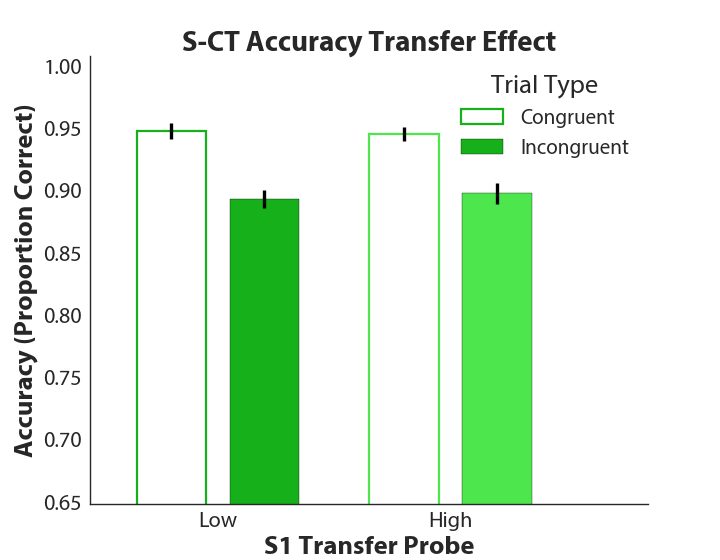

In [120]:
barwidth = 0.75; 
fig, ax = plt.subplots(figsize=(9, 7));
rects1 = ax.bar(0.5,ACCanalysis.LowC.mean(),barwidth,yerr=ACCstderror.LowC,ecolor='k',edgecolor=sns.xkcd_rgb['green'],linewidth = 2, facecolor='none',error_kw=dict(lw=3),label='Congruent');
rects2 = ax.bar(1.5,ACCanalysis.LowIC.mean(),barwidth,color=sns.xkcd_rgb['green'],yerr=ACCstderror.LowIC,ecolor='k',error_kw=dict(lw=3),label='Incongruent');
rects3 = ax.bar(3,ACCanalysis.HighC.mean(),barwidth,yerr=ACCstderror.HighC,ecolor='k',edgecolor=(0.3,0.9,0.3),linewidth = 2, facecolor='none',error_kw=dict(lw=3));
rects4 = ax.bar(4,ACCanalysis.HighIC.mean(),barwidth,color=(0.3,0.9,0.3),yerr=ACCstderror.HighIC,ecolor='k',error_kw=dict(lw=3));
sns.set(context='notebook', style='white', font='Myriad Pro', font_scale=2, color_codes=False, rc=None);
ax.set_ylim(0.65,1.01);
ax.set_xlim(0,6);
ax.set_xticklabels(('Low', 'High'));
ax.set_xticks([1 + barwidth/2, 3.5 + barwidth/2]);
ax.set_yticks(np.arange(0.65, 1.01, 0.05));
plt.legend([rects1,rects2], ['Congruent','Incongruent'], loc='upper right',fontsize=18,title='Trial Type')
plt.legend(title='Trial Type',fontsize=19)
plt.title('S-CT Accuracy Transfer Effect', fontsize=26,fontweight="bold")
plt.ylabel('Accuracy (Proportion Correct)', fontsize=24,fontweight="bold")
plt.xlabel('S1 Transfer Probe', fontsize=24,fontweight="bold")
sns.despine();

plt.show()

<IPython.core.display.Javascript object>


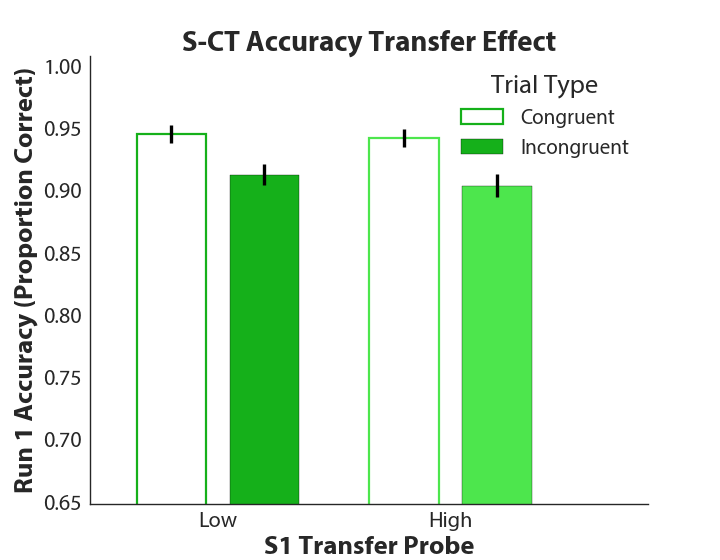

In [121]:
barwidth = 0.75; 
fig, ax = plt.subplots(figsize=(9, 7));
rects1 = ax.bar(0.5,Run1ACC.LowC.mean(),barwidth,yerr=ACCstderror_Run1.LowC,ecolor='k',edgecolor=sns.xkcd_rgb['green'],linewidth = 2, facecolor='none',error_kw=dict(lw=3),label='Congruent');
rects2 = ax.bar(1.5,Run1ACC.LowIC.mean(),barwidth,color=sns.xkcd_rgb['green'],yerr=ACCstderror_Run1.LowIC,ecolor='k',error_kw=dict(lw=3),label='Incongruent');
rects3 = ax.bar(3,Run1ACC.HighC.mean(),barwidth,yerr=ACCstderror_Run1.HighC,ecolor='k',edgecolor=(0.3,0.9,0.3),linewidth = 2, facecolor='none',error_kw=dict(lw=3));
rects4 = ax.bar(4,Run1ACC.HighIC.mean(),barwidth,color=(0.3,0.9,0.3),yerr=ACCstderror_Run1.HighIC,ecolor='k',error_kw=dict(lw=3));
sns.set(context='notebook', style='white', font='Myriad Pro', font_scale=2, color_codes=False, rc=None);
ax.set_ylim(0.65,1.01);
ax.set_xlim(0,6);
ax.set_xticklabels(('Low', 'High'));
ax.set_xticks([1 + barwidth/2, 3.5 + barwidth/2]);
ax.set_yticks(np.arange(0.65, 1.01, 0.05));
plt.legend([rects1,rects2], ['Congruent','Incongruent'], loc='upper right',fontsize=18,title='Trial Type');
plt.legend(title='Trial Type',fontsize=19);
plt.title('S-CT Accuracy Transfer Effect', fontsize=26,fontweight="bold");
plt.ylabel('Run 1 Accuracy (Proportion Correct)', fontsize=24,fontweight="bold");
plt.xlabel('S1 Transfer Probe', fontsize=24,fontweight="bold");
sns.despine();

plt.show()

<IPython.core.display.Javascript object>


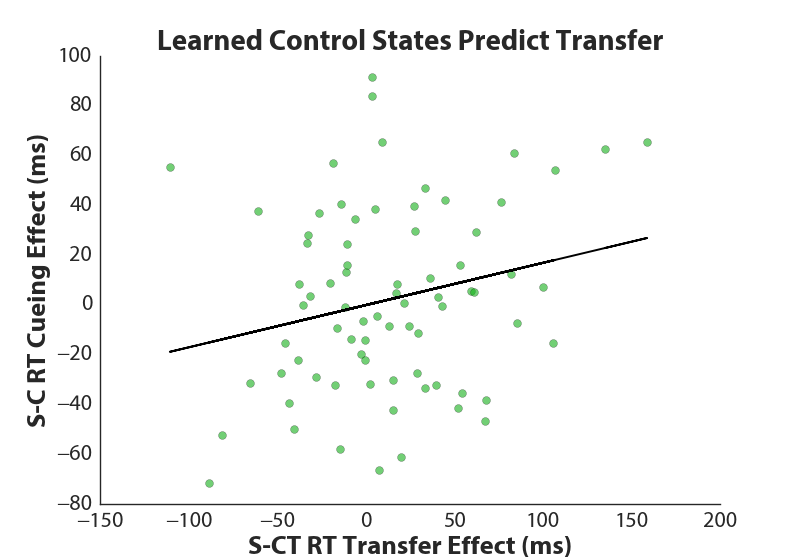

LinregressResult(slope=0.16978530716275489, intercept=-0.087017992133370914, rvalue=0.23066014007479185, pvalue=0.045001326686669792, stderr=0.083260665452909222)

In [154]:
from pylab import polyfit, poly1d
fig, ax = plt.subplots(figsize=(10, 7));
plt.scatter(SCTRTcueing, SCRTcueing, s=50,c=sns.xkcd_rgb['green'],alpha=0.6,edgecolors='k');
sns.set(context='notebook', style='white', font='Myriad Pro', font_scale=2, color_codes=False, rc=None);
fit = polyfit(SCTRTcueing, SCRTcueing, 1);
fit_fn = poly1d(fit);
plt.plot(SCTRTcueing, fit_fn(SCTRTcueing), 'k');
plt.title('Learned Control States Predict Transfer', fontsize=26,fontweight="bold");
plt.ylabel('S-C RT Cueing Effect (ms)', fontsize=24,fontweight="bold");
plt.xlabel('S-CT RT Transfer Effect (ms)', fontsize=24,fontweight="bold");
sns.despine();

plt.show()
stats.linregress(SCTRTcueing,SCRTcueing) #see stats below graph

# Making CSV Copies of the Data

If you like handling the data yourself, these CSVs organize the data by the relevant variables.

In [123]:
%cd 'csvdata'

C:\Users\cb383\Documents\controltransfer\expt1\data\csvdata


In [124]:
subrunmeans = cdat.groupby(['subject','RunCounter','ContextCong'])['RT'].mean()
subrtmeans = cdat.groupby(['subject', 'ContextCong'])['RT'].mean()
subrunmedians = cdat.groupby(['subject','RunCounter','ContextCong'])['RT'].median()
subrtmedians = cdat.groupby(['subject', 'ContextCong'])['RT'].median()

subrunmeans.to_csv('SCT_RTsubrunmeans_subRunTTContext.csv')
subrunmedians.to_csv('SCT_RTsubrunmedians_subRunTTContext.csv')
subrtmeans.to_csv('SCT_RTmeansallsubs_subTTContext.csv')
subrtmedians.to_csv('SCT_RTmediansallsubs_subTTContext.csv')

accmeans = adat.groupby(['subject', 'ContextCong'])['Accuracy'].mean()
subaccmeans = adat.groupby(['subject','RunCounter', 'ContextCong'])['Accuracy'].mean()

accmeans.to_csv('SCT_ACCmeans_subTTContext.csv')
subaccmeans.to_csv('SCT_ACCsubmeans_subrunTTContext.csv')

## Running ANOVAs in R

In [125]:
AN_sub_RTmeans = cdat.groupby(['subject','RunCounter','TransferProbe','TrialType'])['RT'].mean();
AN_sub_ACCmeans = adat.groupby(['subject','RunCounter','TransferProbe','TrialType'])['Accuracy'].mean();
AN_sub_RTmeans_Run1 = cdat.loc[cdat['RunCounter'] < 1].groupby(['subject','TransferProbe','TrialType'])['RT'].mean();
AN_sub_ACCmeans_Run1 = adat.loc[adat['RunCounter'] < 1].groupby(['subject','TransferProbe','TrialType'])['Accuracy'].mean();

#create tidy data csvs
AN_sub_RTmeans.to_csv('SCT_ANOVA_RT.csv')
AN_sub_ACCmeans.to_csv('SCT_ANOVA_ACC.csv')
AN_sub_RTmeans_Run1.to_csv('SCT_ANOVA_RT_R1.csv')
AN_sub_ACCmeans_Run1.to_csv('SCT_ANOVA_ACC_R1.csv')

#create headers for the tidy data csvs, for analysis purposes
import csv
with open('SCT_ANOVA_RT.csv',newline='') as f:
    r = csv.reader(f)
    data = [line for line in r]
with open('SCT_ANOVA_RT.csv','w',newline='') as f:
    w = csv.writer(f)
    w.writerow(["subject", "run", "probe", "trialtype", "rt"])
    w.writerows(data)

with open('SCT_ANOVA_ACC.csv',newline='') as f:
    r = csv.reader(f)
    data = [line for line in r]
with open('SCT_ANOVA_ACC.csv','w',newline='') as f:
    w = csv.writer(f)
    w.writerow(["subject", "run", "probe", "trialtype", "acc"])
    w.writerows(data)

with open('SCT_ANOVA_RT_R1.csv',newline='') as f:
    r = csv.reader(f)
    data = [line for line in r]
with open('SCT_ANOVA_RT_R1.csv','w',newline='') as f:
    w = csv.writer(f)
    w.writerow(["subject", "probe", "trialtype", "rt"])
    w.writerows(data)

with open('SCT_ANOVA_ACC_R1.csv',newline='') as f:
    r = csv.reader(f)
    data = [line for line in r]
with open('SCT_ANOVA_ACC_R1.csv','w',newline='') as f:
    w = csv.writer(f)
    w.writerow(["subject", "probe", "trialtype", "acc"])
    w.writerows(data)

In [126]:
%%writefile SCTAnova.R

rawRTData <- read.csv('SCT_ANOVA_RT.csv')
install.packages("psych",repos='https://mirrors.nics.utk.edu/cran/')
install.packages("ez",repos='https://mirrors.nics.utk.edu/cran/')
library(psych)
library(ez)

rawRTData$subject = as.factor(rawRTData$subject)
rawRTData$run = as.factor(rawRTData$run)
rawRTData$probe = as.factor(rawRTData$probe)
rawRTData$trialtype = as.factor(rawRTData$trialtype)

SCT_RT_runANOVA <- ezANOVA(data=as.data.frame(rawRTData),
                                  dv=rt,
                                  wid=subject,
                                  within=.(run, probe, trialtype),
                                  detailed=TRUE)
print(SCT_RT_runANOVA)

rawACCData <- read.csv('SCT_ANOVA_ACC.csv')

rawACCData$subject = as.factor(rawACCData$subject)
rawACCData$run = as.factor(rawACCData$run)
rawACCData$probe = as.factor(rawACCData$probe)
rawACCData$trialtype = as.factor(rawACCData$trialtype)

SCT_ACC_runANOVA <- ezANOVA(data=as.data.frame(rawACCData),
                                  dv=acc,
                                  wid=subject,
                                  within=.(run, probe, trialtype),
                                  detailed=TRUE)
print(SCT_ACC_runANOVA)

rawRTData_R1 <- read.csv('SCT_ANOVA_RT_R1.csv')

rawRTData_R1$subject = as.factor(rawRTData_R1$subject)
rawRTData_R1$probe = as.factor(rawRTData_R1$probe)
rawRTData_R1$trialtype = as.factor(rawRTData_R1$trialtype)

SCT_RT_runANOVA_R1 <- ezANOVA(data=as.data.frame(rawRTData_R1),
                                  dv=rt,
                                  wid=subject,
                                  within=.(probe, trialtype),
                                  detailed=TRUE)
print(SCT_RT_runANOVA_R1)

rawACCData_R1 <- read.csv('SCT_ANOVA_ACC_R1.csv')

rawACCData_R1$subject = as.factor(rawACCData_R1$subject)
rawACCData_R1$probe = as.factor(rawACCData_R1$probe)
rawACCData_R1$trialtype = as.factor(rawACCData_R1$trialtype)

SCT_ACC_runANOVA_R1 <- ezANOVA(data=as.data.frame(rawACCData_R1),
                                  dv=acc,
                                  wid=subject,
                                  within=.(probe, trialtype),
                                  detailed=TRUE)
print(SCT_ACC_runANOVA_R1)

Overwriting SCTAnova.R


In [127]:
! Rscript SCTAnova.R

package 'psych' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\cb383\AppData\Local\Temp\Rtmp6TFnND\downloaded_packages
package 'ez' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\cb383\AppData\Local\Temp\Rtmp6TFnND\downloaded_packages
$ANOVA
               Effect DFn DFd          SSn        SSd            F            p
1         (Intercept)   1  75 2.669810e+08 1145621.77 1.747835e+04 1.303673e-90
2                 run   1  75 7.670927e+00  115242.15 4.992267e-03 9.438596e-01
3               probe   1  75 1.539888e+03   37664.56 3.066320e+00 8.401884e-02
4           trialtype   1  75 6.996028e+05  118780.70 4.417402e+02 3.657208e-33
5           run:probe   1  75 8.912127e+00   42803.87 1.561564e-02 9.008876e-01
6       run:trialtype   1  75 9.019016e+02   42248.46 1.601067e+00 2.096691e-01
7     probe:trialtype   1  75 2.806717e+02   36700.60 5.735705e-01 4.512165e-01
8 run:probe:trialtype   1  7

trying URL 'https://mirrors.nics.utk.edu/cran/bin/windows/contrib/3.3/psych_1.7.5.zip'
Content type 'application/zip' length 3967128 bytes (3.8 MB)
downloaded 3.8 MB

trying URL 'https://mirrors.nics.utk.edu/cran/bin/windows/contrib/3.3/ez_4.4-0.zip'
Content type 'application/zip' length 304757 bytes (297 KB)
downloaded 297 KB

Warning message:
package 'psych' was built under R version 3.3.3 
Warning message:
package 'ez' was built under R version 3.3.3 


# Making 95% Confidence Intervals

In [128]:
import statsmodels.stats.api as sms

a = RTanalysis.LowC.mean()
sms.DescrStatsW(RTanalysis.LowC).tconfint_mean()
#a

(615.82992183978354, 636.90379041157098)

In [129]:
a = RTanalysis.LowIC.mean()
sms.DescrStatsW(RTanalysis.LowIC).tconfint_mean()
#a

(684.5940846391843, 706.32381475882062)

In [130]:
a = RTanalysis.HighC.mean()
sms.DescrStatsW(RTanalysis.HighC).tconfint_mean()
#a

(619.7954775740593, 642.01807402405257)

In [131]:
a = RTanalysis.HighIC.mean()
sms.DescrStatsW(RTanalysis.HighIC).tconfint_mean()
#a

(686.78755898520387, 707.94550362973598)

In [132]:
a = RTrunanalysis.loc[RTrunanalysis['Run'] == 0].LowC.mean()
sms.DescrStatsW(RTrunanalysis.loc[RTrunanalysis['Run'] == 0].LowC).tconfint_mean()
#a

(614.05622917096855, 636.27256950916842)

In [133]:
a = RTrunanalysis.loc[RTrunanalysis['Run'] == 0].LowIC.mean()
sms.DescrStatsW(RTrunanalysis.loc[RTrunanalysis['Run'] == 0].LowIC).tconfint_mean()
#a

(685.83308509423432, 708.06272541620456)

In [134]:
a = RTrunanalysis.loc[RTrunanalysis['Run'] == 0].HighC.mean()
sms.DescrStatsW(RTrunanalysis.loc[RTrunanalysis['Run'] == 0].HighC).tconfint_mean()
#a

(622.75472487514924, 647.17727976881349)

In [135]:
a = RTrunanalysis.loc[RTrunanalysis['Run'] == 0].HighIC.mean()
sms.DescrStatsW(RTrunanalysis.loc[RTrunanalysis['Run'] == 0].HighIC).tconfint_mean()
#a

(683.36087912455355, 704.63188357449576)

In [136]:
a = RTrunanalysis.loc[RTrunanalysis['Run'] == 1].LowC.mean()
sms.DescrStatsW(RTrunanalysis.loc[RTrunanalysis['Run'] == 1].LowC).tconfint_mean()
#a

(615.54353043798483, 639.98386323647492)

In [137]:
a = RTrunanalysis.loc[RTrunanalysis['Run'] == 1].LowIC.mean()
sms.DescrStatsW(RTrunanalysis.loc[RTrunanalysis['Run'] == 1].LowIC).tconfint_mean()
#a

(681.62095234078231, 707.14623731386348)

In [138]:
a = RTrunanalysis.loc[RTrunanalysis['Run'] == 1].HighC.mean()
sms.DescrStatsW(RTrunanalysis.loc[RTrunanalysis['Run'] == 1].HighC).tconfint_mean()
#a

(615.50094361194544, 638.59031220656209)

In [139]:
a = RTrunanalysis.loc[RTrunanalysis['Run'] == 1].HighIC.mean()
sms.DescrStatsW(RTrunanalysis.loc[RTrunanalysis['Run'] == 1].HighIC).tconfint_mean()
#a

(688.67164058067033, 713.2947145447954)

And for Accuracy...

In [140]:
a = ACCanalysis.LowC.mean()
sms.DescrStatsW(ACCanalysis.LowC).tconfint_mean()
#a

(0.93717491991364998, 0.9628250800863497)

In [141]:
a = ACCanalysis.LowIC.mean()
sms.DescrStatsW(ACCanalysis.LowIC).tconfint_mean()
#a

(0.88024505140031073, 0.9092286328102156)

In [142]:
a = ACCanalysis.HighC.mean()
sms.DescrStatsW(ACCanalysis.HighC).tconfint_mean()
#a

(0.93584513107380629, 0.95889171103145676)

In [143]:
a = ACCanalysis.HighIC.mean()
sms.DescrStatsW(ACCanalysis.HighIC).tconfint_mean()
#a

(0.88302238755820617, 0.9163197177049518)

In [144]:
a = ACCrunanalysis.loc[ACCrunanalysis['Run'] == 0].LowC.mean()
sms.DescrStatsW(ACCrunanalysis.loc[ACCrunanalysis['Run'] == 0].LowC).tconfint_mean()
#a

(0.93280883397038217, 0.96192800813488089)

In [145]:
a = ACCrunanalysis.loc[ACCrunanalysis['Run'] == 0].LowIC.mean()
sms.DescrStatsW(ACCrunanalysis.loc[ACCrunanalysis['Run'] == 0].LowIC).tconfint_mean()
#a

(0.89780491298035836, 0.93114245544069429)

In [146]:
a = ACCrunanalysis.loc[ACCrunanalysis['Run'] == 0].HighC.mean()
sms.DescrStatsW(ACCrunanalysis.loc[ACCrunanalysis['Run'] == 0].HighC).tconfint_mean()
#a

(0.93012086998384025, 0.95803702475300179)

In [147]:
a = ACCrunanalysis.loc[ACCrunanalysis['Run'] == 0].HighIC.mean()
sms.DescrStatsW(ACCrunanalysis.loc[ACCrunanalysis['Run'] == 0].HighIC).tconfint_mean()
#a

(0.88802837086434538, 0.92381373439881276)

In [148]:
a = ACCrunanalysis.loc[ACCrunanalysis['Run'] == 1].LowC.mean()
sms.DescrStatsW(ACCrunanalysis.loc[ACCrunanalysis['Run'] == 1].LowC).tconfint_mean()
#a

(0.93893436128550289, 0.9663287966092341)

In [149]:
a = ACCrunanalysis.loc[ACCrunanalysis['Run'] == 1].LowIC.mean()
sms.DescrStatsW(ACCrunanalysis.loc[ACCrunanalysis['Run'] == 1].LowIC).tconfint_mean()
#a

(0.85257186803029994, 0.89742813196970006)

In [150]:
a = ACCrunanalysis.loc[ACCrunanalysis['Run'] == 1].HighC.mean()
sms.DescrStatsW(ACCrunanalysis.loc[ACCrunanalysis['Run'] == 1].HighC).tconfint_mean()
#a

(0.93412778227792748, 0.96718800719575682)

In [151]:
a = ACCrunanalysis.loc[ACCrunanalysis['Run'] == 1].HighIC.mean()
sms.DescrStatsW(ACCrunanalysis.loc[ACCrunanalysis['Run'] == 1].HighIC).tconfint_mean()
#a

(0.86994325327587418, 0.91689885198728382)